In [1]:
import time

from PIL import Image
import cv2

import numpy as np
from matplotlib import pyplot as plt

import torch
from torch.utils.data import Dataset

import torchvision
from torchvision import transforms

import albumentations
import albumentations.pytorch

### 1. 기존의 Torchvision 을 이용한 방법

In [2]:
class TorchvisionDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)  # 이미지 데이터 갯수

    def __getitem__(self, idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]
        
        # Read an image with PIL
        image = Image.open(file_path)
        
        start_t = time.time()
        if self.transform:
            image = self.transform(image)
        total_time = (time.time() - start_t)

        return image, label, total_time

#### NOTE ) 아래의 각 transform에 대해서는 https://pytorch.org/docs/stable/torchvision/transforms.html 참조

In [3]:
torchvision_transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.RandomCrop(112),  # If size is an int instead of sequence like (h, w), a square crop (size, size) is made.
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # Converts to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
])

torchvision_dataset = TorchvisionDataset(
    file_paths=['testimg.png'],
    labels=[1],
    transform=torchvision_transform,
)

torchvision time/sample: 3.231785297393799 ms
<class 'torch.Tensor'>


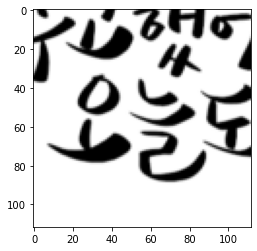

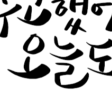

In [4]:
# 실행할 때마다 crop 되는 영역과 이미지의 좌우가 바뀐다.

total_time = 0
for i in range(100):
    sample, _, transform_time = torchvision_dataset[0]
    total_time += transform_time

print("torchvision time/sample: {} ms".format(total_time*10))
print(type(sample))

plt.imshow(transforms.ToPILImage()(sample))
plt.show()
transforms.ToPILImage()(sample)

PNG RGB (484, 512) 484 512
(512, 484, 3)


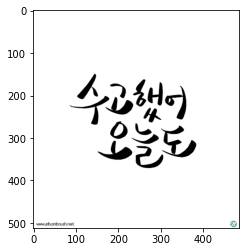

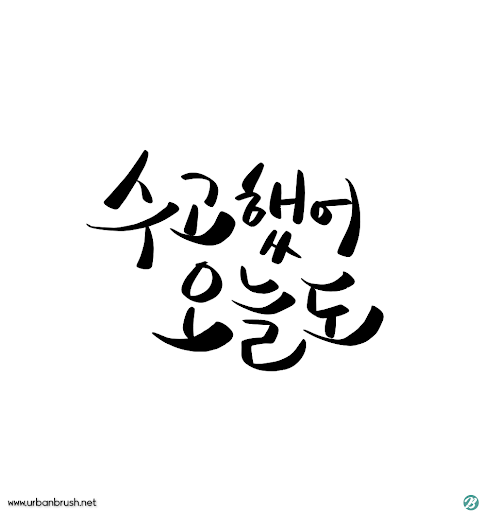

In [5]:
# Pillow 로 이미지 원본 확인

img = Image.open('testimg.png')
print(img.format, img.mode, img.size, img.width, img.height)  # size 는 (width, height) 순이다.
img_array = np.array(img)
print(img_array.shape)  # numpy.ndarray 로 변환하면 (height, width, color) 순이다.
plt.imshow(img_array)
plt.show()
transforms.ToPILImage()(img_array)

### 2. Albumentations 적용 

#### NOTE ) OpenCV 를 이용한다.

In [6]:
class AlbumentationsDataset(Dataset):
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]
        
        # Read an image with OpenCV
        image = cv2.imread(file_path)
        
        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        start_t = time.time()
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        total_time = (time.time() - start_t)
        return image, label, total_time

#### NOTE ) 아래의 각 transform 은 https://albumentations.readthedocs.io/en/latest/api/index.html 참조 

In [7]:
albumentations_transform = albumentations.Compose([
    albumentations.Resize(256, 256),  # height, width 순으로 별개의 파라미터로 대입
    albumentations.RandomCrop(112, 112),  # height, width 순으로 별개의 파라미터로 대입
    albumentations.HorizontalFlip(),  # Same with transforms.RandomHorizontalFlip()
    # ToTensor() below Converts to a torch.Tensor of shape (C x H x W) and devides by 255,
    # so makes tensor in the range [0.0, 1.0].
    albumentations.pytorch.transforms.ToTensor()
])

albumentations_dataset = AlbumentationsDataset(
    file_paths=["testimg.png"],
    labels=[1],
    transform=albumentations_transform,
)

albumentations time/sample: 0.11966705322265625 ms
<class 'torch.Tensor'>


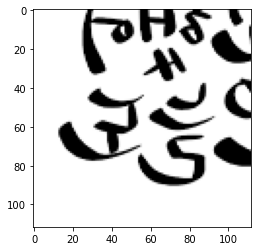

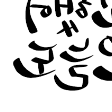

In [8]:
# 실행할 때마다 crop 되는 영역과 이미지의 좌우가 바뀐다.

total_time = 0
for i in range(100):
    sample, _, transform_time = albumentations_dataset[0]
    total_time += transform_time

print("albumentations time/sample: {} ms".format(total_time*10))
print(type(sample))

plt.imshow(transforms.ToPILImage()(sample))
plt.show()
transforms.ToPILImage()(sample)

<class 'numpy.ndarray'> (512, 484, 3)
(512, 484)


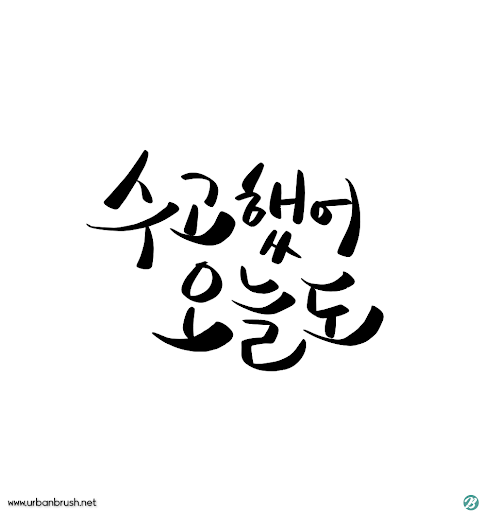

In [9]:
# OpenCV 로 이미지 원본 확인

img = cv2.imread('testimg.png')
print(type(img), img.shape)  # 바로 numpy.ndarray 형태로 출력

# print(img)

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 흑백으로 전환
print(img.shape)
transforms.ToPILImage()(img_array)  # PIL image 로 전환

In [10]:
# OneOf 사용하기

albumentations_transform_oneof = albumentations.Compose([
    albumentations.Resize(256, 256), 
    albumentations.RandomCrop(112, 112),
    albumentations.OneOf([                
        albumentations.HorizontalFlip(p=1),  # HorizontalFlip Default : always_apply=False, p=0.5
        albumentations.RandomRotate90(p=1),  # RandomRotate90 Default : always_apply=False, p=0.5
        albumentations.VerticalFlip(p=1)  # VerticalFlip Default : always_apply=False, p=0.5         
    ], p=1),
    albumentations.OneOf([
        # MotionBlur Default : blur_limit=7, always_apply=False, p=0.5
        albumentations.MotionBlur(p=1),
        albumentations.OpticalDistortion(p=1),
        # GaussNoise Default : var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5
        albumentations.GaussNoise(p=1)                 
    ], p=1),
    albumentations.pytorch.ToTensor()  # albumentations.pytorch.transforms.ToTensor() 에서 transforms 생략가능
])

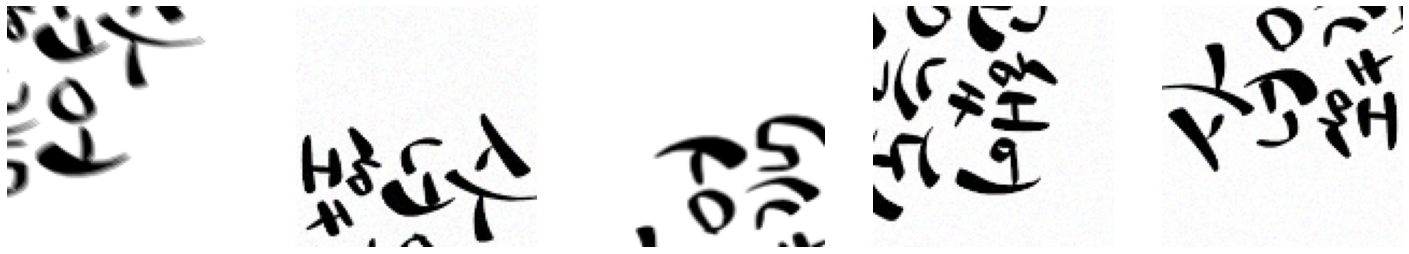

In [11]:
albumentations_dataset = AlbumentationsDataset(
    file_paths=['testimg.png'],
    labels=[1],
    transform=albumentations_transform_oneof,
)

num_samples = 5
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
    ax[i].imshow(transforms.ToPILImage()(albumentations_dataset[0][0]))
    ax[i].axis('off')